In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
print(sys.version)

c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


3.7.3 (v3.7.3:ef4ec6ed12, Mar 25 2019, 22:22:05) [MSC v.1916 64 bit (AMD64)]


In [2]:
def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

def normalization(train):
    feature_scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(feature_scaler.fit_transform(train.values), columns=train.columns, index=train.index)
    return X_scaled

In [4]:
from imblearn.over_sampling import SMOTE

def smoteOverSamling(train,nn,r):
    sm = SMOTE(random_state=42, k_neighbors = nn, ratio = r)
    return sm.fit_sample(train.drop('fraud',axis=1), train['fraud'])

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



train_pure=pd.read_csv('train.csv',sep=',',index_col=0)
x_pure= train_pure.drop('fraud',axis=1)
y_pure= train_pure['fraud']

x_train, x_holdout, y_train, y_holdout = train_test_split(x_pure, y_pure, test_size=0.2, random_state=324)

x_train= normalization(x_train)
x_holdout= normalization(x_holdout)

## Logistic regression 

In [6]:
attr_dim= x_holdout.shape[1]
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=attr_dim))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(x_train, y_train, nb_epoch=100, validation_data=(x_holdout, y_holdout),verbose=0)

y_pred = model.predict(x_holdout).astype(int)
validation_accuracy= my_custom_loss_func(y_holdout,y_pred)

W0701 14:41:38.809055  9004 deprecation_wrapper.py:119] From c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 14:41:38.821008  9004 deprecation_wrapper.py:119] From c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 14:41:38.822969  9004 deprecation_wrapper.py:119] From c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 14:41:38.832977  9004 deprecation_wrapper.py:119] From c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Pl

[[351   0]
 [ 25   0]]


In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

## Logistic regression with hyper-parameter tuning

In [8]:
from keras.optimizers import Adam
from keras.regularizers import l1_l2
cost=[]
val_cost=[]
num_iters = [50]#[50,100]
best_val = -100
regularization_strengths = [1e-1,1e1] # [1e-1,1e1,1e2, 1e3, 1e4, 1e5]
learning_rates =  [1e-3, 1e-6] # [1e-2, 1e-3, 1e-4, 1e-5,1e-6]
for l_rate in learning_rates:
    for r in regularization_strengths:
        for iterations in num_iters:
            reg = l1_l2(l1=r, l2=r)
            model = Sequential()
            model.add(Dense(1, activation='sigmoid', W_regularizer=reg, input_dim=attr_dim))
            opt= Adam(lr=l_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
            model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
            history=model.fit(x_train, y_train, epochs=iterations,  batch_size=256,validation_data=(x_holdout, y_holdout),verbose=0)
           
            y_pred = model.predict(x_holdout).astype(int)
            validation_cost= my_custom_loss_func(y_holdout,y_pred)
            val_cost.append(validation_cost)
    
            if validation_cost > best_val:
                best_cost= cost
                best_val_cost = val_cost
                best_history=history
                best_reg=r
                best_iter=iterations
                best_lr=l_rate
                best_val = validation_cost 
                best_model = model

c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=20, kernel_regularizer=<keras.reg...)`
  


[[351   0]
 [ 25   0]]
[[351   0]
 [ 25   0]]
[[351   0]
 [ 25   0]]
[[351   0]
 [ 25   0]]


In [9]:
best_reg, best_iter, best_lr, best_val 


(0.1, 50, 0.001, -0.3324468085106383)

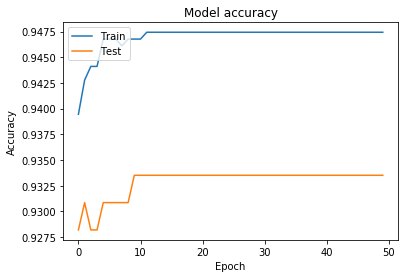

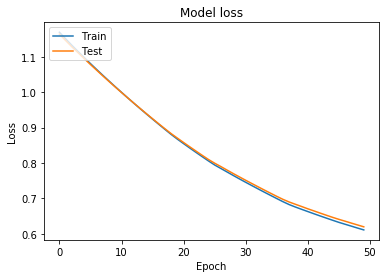

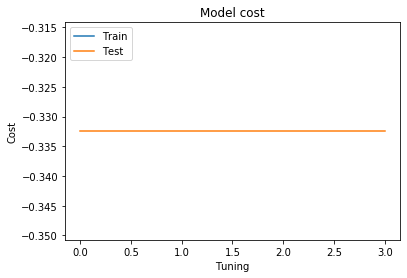

In [10]:
plt.plot(best_history.history['acc'])
plt.plot(best_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
            
            # Plot training & validation loss values
plt.plot(cost)
plt.plot(val_cost)
plt.title('Model cost')
plt.ylabel('Cost')
plt.xlabel('Tuning')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Neural network with 1 hidden layer and tuning

In [11]:
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l1_l2
cost=[]
val_cost=[]
num_iters = [50]#[500, 1000]
best_val = -100
regularization_strengths = [1e-1,1e1] #[1e-1,1e1,1e2, 1e3, 1e4, 1e5]
learning_rates = [1e-3, 1e-6]#[1e-2, 1e-3, 1e-4, 1e-5,1e-6]
hidden_layers= [2,8]#[2, 4, 8, 16, 32,64]
dropout = [0.5] #[0.0,0.5]
for hid in hidden_layers:
    for dr in dropout:
        for l_rate in learning_rates:
            for r in regularization_strengths:
                for iterations in num_iters:
                    input_dim= x_train.shape[1]
                    reg = l1_l2(l1=r, l2=r)
                    model = Sequential()
                    model.add(Dense(hid, input_dim=input_dim, init='uniform',
                        W_regularizer=reg,
                        bias_regularizer=reg
                    ))
                    
                    model.add(BatchNormalization())
                    model.add(Activation('relu'))
                    model.add(Dropout(dr))
                    
                    model.add(Dense(1, activation='sigmoid', input_dim=(hid,),
                       W_regularizer=reg,
                        bias_regularizer=reg
                    ))
                    
                    opt= Adam(lr=l_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
                    
                    model.compile(optimizer= opt, loss='binary_crossentropy',metrics=['accuracy'])
                    history=model.fit(x_train, y_train, epochs=iterations,  batch_size=256,validation_data=(x_holdout, y_holdout),verbose=0)
                   
                    y_pred = model.predict(x_holdout).astype(int)
                    validation_cost= my_custom_loss_func(y_holdout,y_pred)
                    val_cost.append(validation_cost)

            
                    if validation_cost > best_val:
                        best_cost= cost
                        best_val_cost = val_cost
                        best_history=history
                        best_reg=r
                        best_iter=iterations
                        best_lr=l_rate
                        best_val = validation_cost 
                        best_model = model
                        best_hid=hid
                        best_dr=dr



c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
W0701 14:41:45.415995  9004 deprecation.py:506] From c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(2,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(2,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(2,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(2,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(8,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(8,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(8,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, input_dim=20, bias_regularizer=<keras.reg..., kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
c:\users\christos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", input_dim=(8,), bias_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`


[[351   0]
 [ 25   0]]


In [12]:
best_reg, best_iter, best_lr, best_val,best_hid,best_dr

(0.1, 50, 0.001, -0.3324468085106383, 2, 0.5)

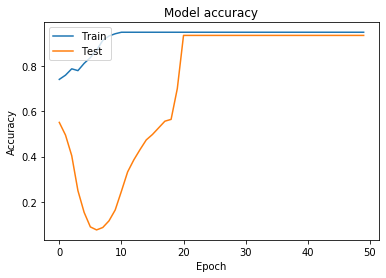

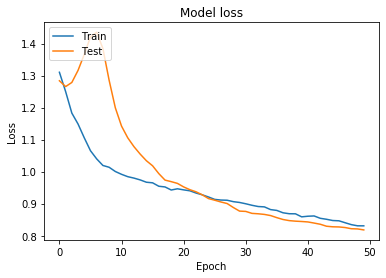

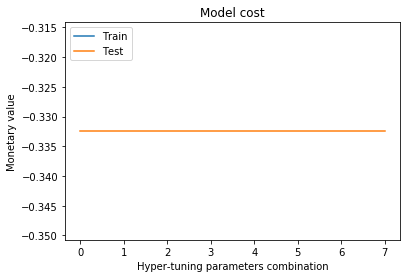

In [13]:
plt.plot(best_history.history['acc'])
plt.plot(best_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
            
            # Plot training & validation loss values
plt.plot(cost)
plt.plot(val_cost)
plt.title('Model cost')
plt.ylabel('Monetary value')
plt.xlabel('Hyper-tuning parameters combination')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()